In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
gdf = gpd.read_file("limites_adm_geoportal_distrito_municipal.geojson")
df = pd.read_csv("unified_points_with_detections.csv")

In [3]:
ml_df = df.copy()
ml_df = ml_df.drop(columns=['downloaded', 'image_path', 'bbox_centers', 'bbox_centers_coords'])

In [4]:
ml_df.head()

,filename,distrito,cd_indice_vulnerabilidade_social,latitude,longitude,pool_count
0,TATUAPE.geojson,TATUAPE,1.0,-23.538247,-46.573478,3
1,TATUAPE.geojson,TATUAPE,1.0,-23.541442,-46.569149,0
2,TATUAPE.geojson,TATUAPE,2.0,-23.536791,-46.569429,0
3,TATUAPE.geojson,TATUAPE,2.0,-23.531662,-46.569968,0
4,TATUAPE.geojson,TATUAPE,2.0,-23.542185,-46.577823,0


In [5]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8816 entries, 0 to 8815
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   filename                          8816 non-null   object 
 1   distrito                          8816 non-null   object 
 2   cd_indice_vulnerabilidade_social  8592 non-null   float64
 3   latitude                          8816 non-null   float64
 4   longitude                         8816 non-null   float64
 5   pool_count                        8816 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 413.4+ KB


In [6]:
ml_df['distrito'].value_counts()

distrito
TATUAPE         100
CIDADE DUTRA    100
CAMPO BELO      100
PIRITUBA        100
MORUMBI         100
               ... 
CAMBUCI          36
BOM RETIRO       34
BARRA FUNDA      21
JAGUARA          18
PARI             17
Name: count, Length: 96, dtype: int64

In [7]:
ml_df.describe()

,cd_indice_vulnerabilidade_social,latitude,longitude,pool_count
count,8592.000000,8816.000000,8816.000000,8816.000000
mean,2.420158,-23.564894,-46.613594,0.394964
std,1.414676,0.078951,0.108997,1.042638
min,0.000000,-23.959451,-46.820487,0.000000
25%,2.000000,-23.604752,-46.696958,0.000000
50%,2.000000,-23.555497,-46.636952,0.000000
75%,3.000000,-23.509330,-46.528674,0.000000
max,6.000000,-23.388394,-46.366345,11.000000


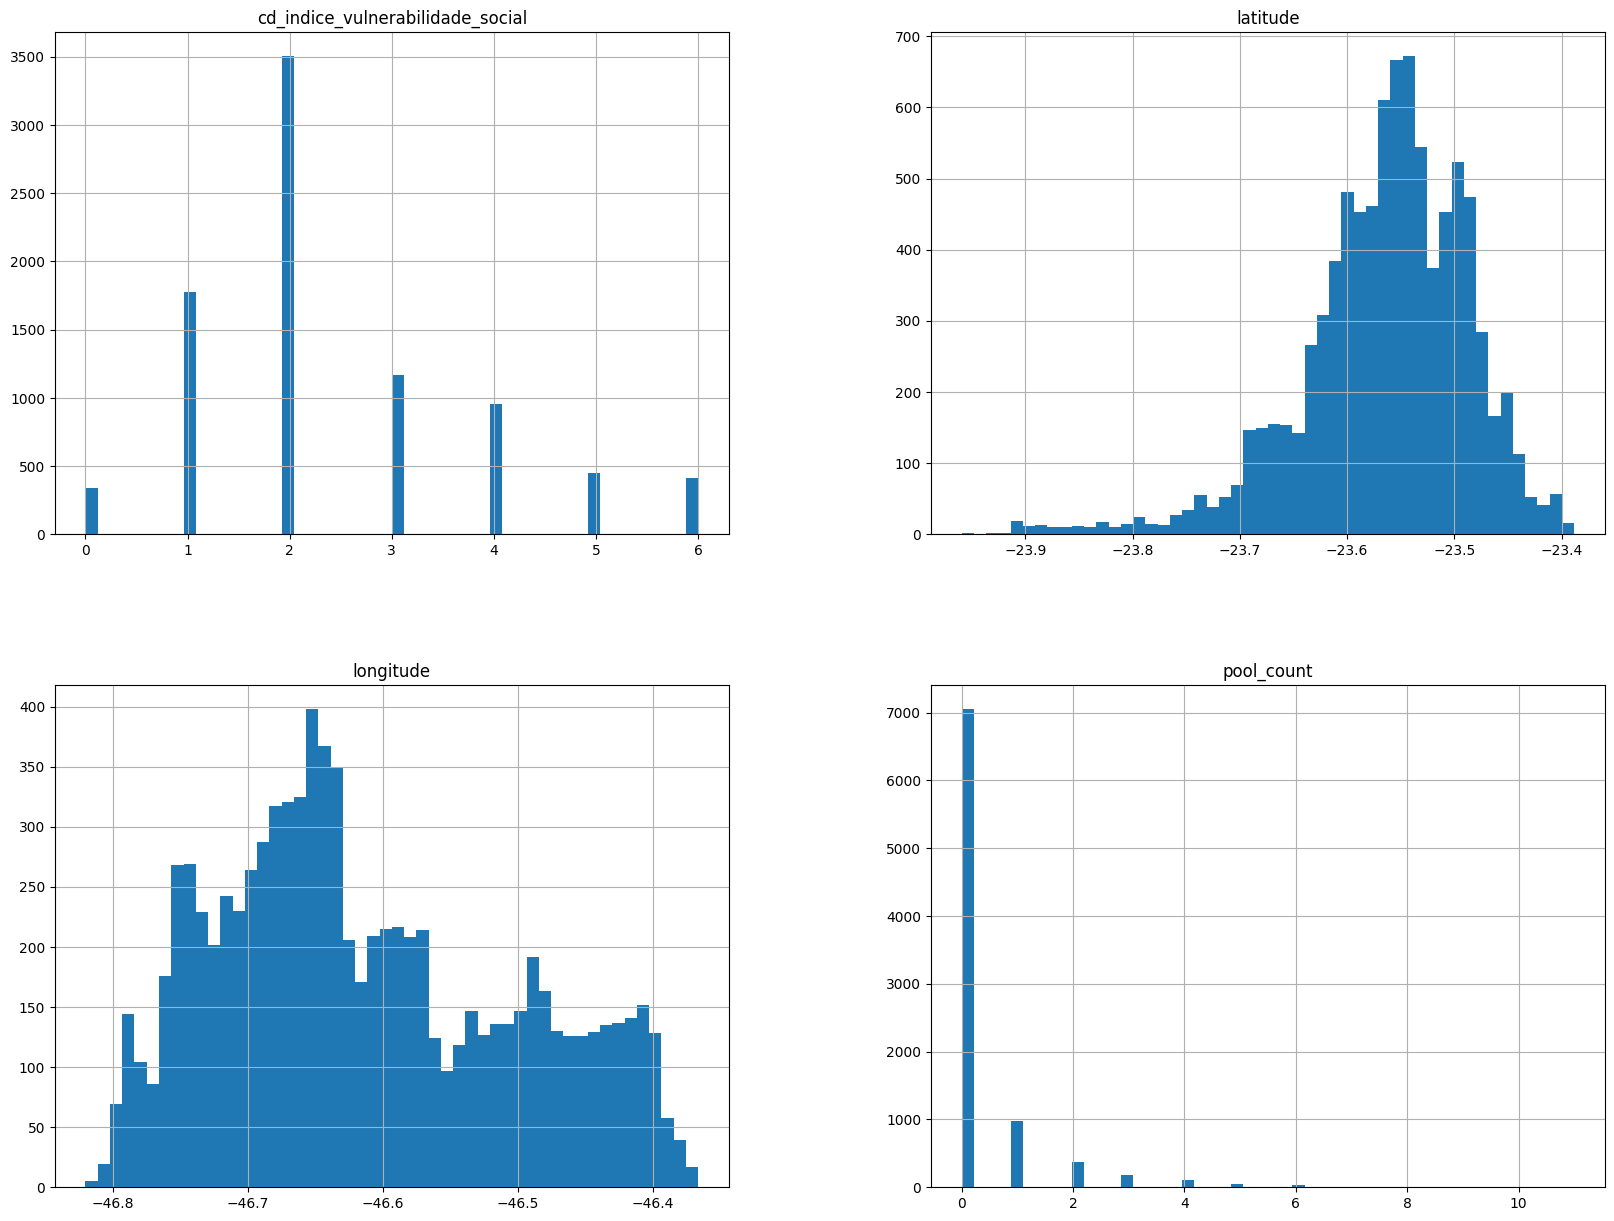

In [8]:
ml_df.hist(bins=50, figsize=(20,15))
plt.show()

### The target variable is heavily unbalanced!

<Axes: >

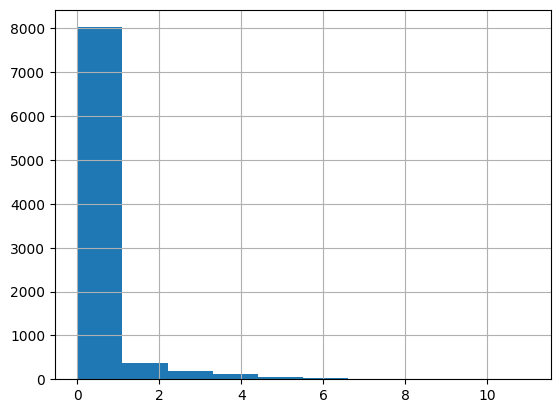

In [9]:
ml_df['pool_count'].hist()

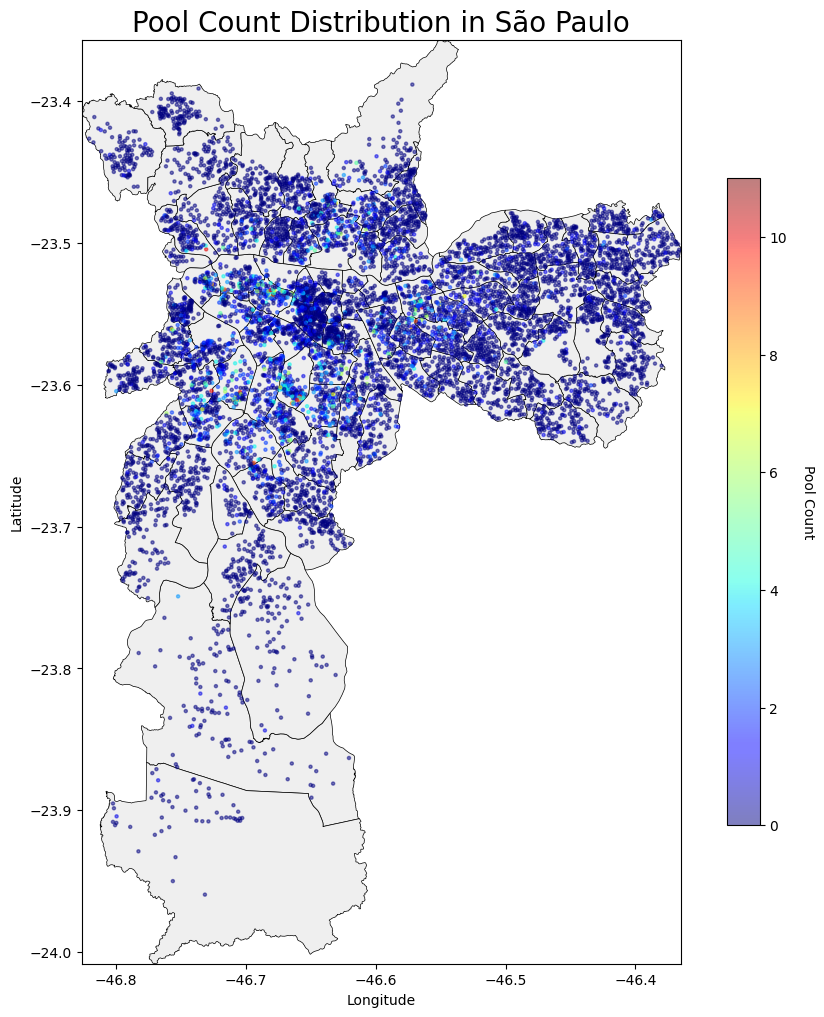

In [10]:
# Load and prepare the map data
gdf = gpd.read_file("limites_adm_geoportal_distrito_municipal.geojson")
gdf_wgs84 = gdf.to_crs(epsg=4326)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

gdf_wgs84.plot(ax=ax, color='#EFEFEF', edgecolor='black', linewidth=0.5)

scatter_plot = ax.scatter(
    x=ml_df["longitude"],
    y=ml_df["latitude"],
    alpha=0.5,
    s=5,                                 
    c=ml_df["pool_count"],               
    cmap=plt.get_cmap("jet")
)

cbar = plt.colorbar(scatter_plot, shrink=0.7)
cbar.set_label("Pool Count", rotation=270, labelpad=20)

ax.set_title("Pool Count Distribution in São Paulo", fontsize=20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_xlim(gdf_wgs84.total_bounds[0], gdf_wgs84.total_bounds[2])
ax.set_ylim(gdf_wgs84.total_bounds[1], gdf_wgs84.total_bounds[3])

plt.show()

In [11]:
district_analysis_df = ml_df.groupby('distrito').agg(
    mean_vulnerability=('cd_indice_vulnerabilidade_social', 'mean'),
    total_pools=('pool_count', 'sum')
).reset_index()

In [12]:
district_analysis_df.head(10)

,distrito,mean_vulnerability,total_pools
0,AGUA RASA,1.920000,64
1,ALTO DE PINHEIROS,1.203704,57
2,ANHANGUERA,2.712766,5
3,ARICANDUVA,2.520408,9
4,ARTUR ALVIM,2.464646,12
5,BARRA FUNDA,1.437500,10
6,BELA VISTA,1.454545,32
7,BELEM,2.150943,19
8,BOM RETIRO,2.411765,8
9,BRAS,2.365854,5


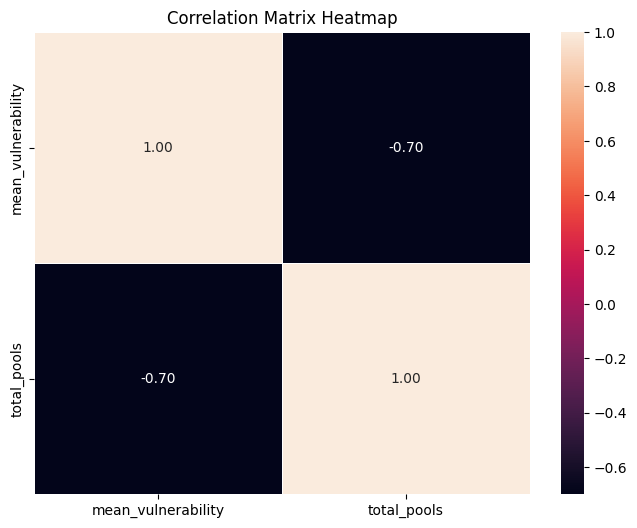

In [13]:
correlation_matrix = district_analysis_df[['mean_vulnerability', 'total_pools']].corr()

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<Axes: xlabel='mean_vulnerability', ylabel='total_pools'>

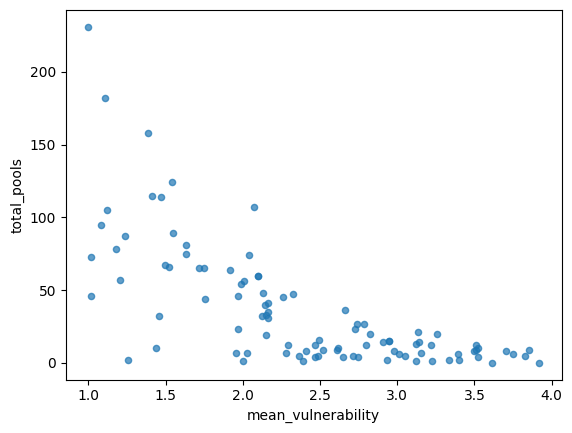

In [14]:
district_analysis_df.plot(kind="scatter", x="mean_vulnerability", y="total_pools", alpha=0.7)

#### As expected, negative correlation

In [15]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8816 entries, 0 to 8815
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   filename                          8816 non-null   object 
 1   distrito                          8816 non-null   object 
 2   cd_indice_vulnerabilidade_social  8592 non-null   float64
 3   latitude                          8816 non-null   float64
 4   longitude                         8816 non-null   float64
 5   pool_count                        8816 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 413.4+ KB


In [16]:
ml_df['cd_indice_vulnerabilidade_social'] = ml_df.groupby('distrito')['cd_indice_vulnerabilidade_social'].transform(
    lambda x: x.fillna(x.mean())
)

In [17]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8816 entries, 0 to 8815
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   filename                          8816 non-null   object 
 1   distrito                          8816 non-null   object 
 2   cd_indice_vulnerabilidade_social  8816 non-null   float64
 3   latitude                          8816 non-null   float64
 4   longitude                         8816 non-null   float64
 5   pool_count                        8816 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 413.4+ KB


### Models

In [18]:
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

#### Fixing data imbalance

In [19]:
# Undersampling "0" dominance
print("Before Undersampling")
print(ml_df['pool_count'].value_counts())
print(f"\nTotal rows in original dataframe: {len(ml_df)}")

Before Undersampling
pool_count
0     7052
1      974
2      374
3      178
4      113
5       53
6       40
7       11
10       8
8        7
9        5
11       1
Name: count, dtype: int64

Total rows in original dataframe: 8816


In [20]:
majority_class = ml_df[ml_df['pool_count'] == 0]
minority_classes = ml_df[ml_df['pool_count'] != 0]

# We'll reduce it to 2x the size of the combined minority classes.
majority_undersampled = resample(majority_class,
                                 replace=False, 
                                 n_samples=int(len(minority_classes) * 2), 
                                 random_state=42)

ml_df_undersampled = pd.concat([majority_undersampled, minority_classes])

ml_df_undersampled = ml_df_undersampled.sample(frac=1, random_state=42)

# Display the new, undersampled data distribution
print("\nAfter Undersampling")
print(ml_df_undersampled['pool_count'].value_counts())
print(f"\nTotal rows in new undersampled dataframe: {len(ml_df_undersampled)}")


After Undersampling
pool_count
0     3528
1      974
2      374
3      178
4      113
5       53
6       40
7       11
10       8
8        7
9        5
11       1
Name: count, dtype: int64

Total rows in new undersampled dataframe: 5292


In [21]:
train_set, test_set = train_test_split(ml_df_undersampled, test_size=0.2, random_state=42)

### Can we predict pool count given a pair of coordinates (lat, long) and the socioeconomic index?

Since the city of São Paulo is relatively small compared with the Earth, there will be no huge disadvantage of using the latitude and longitude features directly without any proper encoding

In [22]:
X = train_set[['distrito', 'cd_indice_vulnerabilidade_social', 'latitude', 'longitude']]
y = train_set['pool_count']

X_test = test_set[['distrito', 'cd_indice_vulnerabilidade_social', 'latitude', 'longitude']]
y_test = test_set['pool_count']

In [23]:
train_set['pool_count'].value_counts()

pool_count
0     2822
1      779
2      299
3      147
4       82
5       41
6       34
7        9
10       7
8        7
9        5
11       1
Name: count, dtype: int64

In [ ]:
def plot_regression_heatmap(y_true, y_pred_rounded, title="Heatmap of Actual vs. Predicted Values"):
    """
    Generates a heatmap to show the frequency of actual vs. predicted values.
    Also calculates and prints accuracy, precision, and recall.

    Args:
        y_true (pd.Series): The actual target values.
        y_pred_rounded (np.array): The rounded predicted values.
        title (str): Title for the plot.
    """
    y_pred_rounded = np.clip(y_pred_rounded, 0, None).astype(int)

    y_true_int = y_true.astype(int)

    # Get the unique labels from both true and prediction sets to define the matrix size
    labels = np.unique(np.concatenate((y_true_int, y_pred_rounded)))

    # Calculate classification metrics
    accuracy = accuracy_score(y_true_int, y_pred_rounded)
    precision_weighted = precision_score(y_true_int, y_pred_rounded, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true_int, y_pred_rounded, average='weighted', zero_division=0)
    precision_macro = precision_score(y_true_int, y_pred_rounded, average='macro', zero_division=0)
    recall_macro = recall_score(y_true_int, y_pred_rounded, average='macro', zero_division=0)

    print(f"\n--- Classification-like Metrics for {title.replace('Heatmap for ', '')} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (weighted): {recall_weighted:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print("------------------------------------------------------------------")

    cm = confusion_matrix(y_true_int, y_pred_rounded, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis')
    plt.title(title, fontsize=16)
    plt.ylabel('True', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

### Visualizing feature transformation

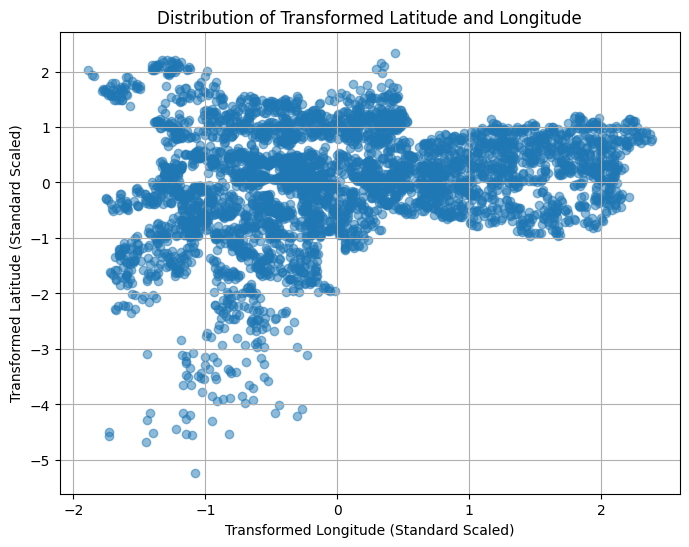

In [26]:
categorical = ['distrito']
numeric = ['cd_indice_vulnerabilidade_social', 'latitude', 'longitude']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numeric)
])

X_transformed = preprocessor.fit_transform(X)
transformed_feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed.toarray(), columns=transformed_feature_names)
transformed_latitude = X_transformed_df['num__latitude']
transformed_longitude = X_transformed_df['num__longitude']

# Visualize the distribution of the transformed latitude and longitude
plt.figure(figsize=(8, 6))
plt.scatter(transformed_longitude, transformed_latitude, alpha=0.5)
plt.title('Distribution of Transformed Latitude and Longitude')
plt.xlabel('Transformed Longitude (Standard Scaled)')
plt.ylabel('Transformed Latitude (Standard Scaled)')
plt.grid(True)
plt.show()

In [27]:
def train_and_evaluate_model(model_name, regressor, X_train, y_train, X_test, y_test, preprocessor, cv=10):
    """
    Trains and evaluates a given regression model using a pipeline.

    Args:
        model_name (str): Name of the model (e.g., 'Linear Regression').
        regressor: The scikit-learn regressor instance.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target values.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target values.
        preprocessor (ColumnTransformer): Preprocessor pipeline.
        cv (int): Number of cross-validation folds.

    Returns:
        tuple: (fitted_pipeline, test_rmse, y_pred_rounded)
    """
    print(f"\n===== Training and Evaluating: {model_name} =====")

    pipeline = Pipeline([
        ('prep', preprocessor),
        (model_name.lower().replace(" ", "_"), regressor)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    print(f"Cross-Validation RMSE Scores: {rmse_scores}")
    print(f"Mean CV RMSE: {rmse_scores.mean():.4f} +/- {rmse_scores.std():.4f}")

    # Fit the model on the full training data
    pipeline.fit(X_train, y_train)
    print("Model fitting complete.")

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_rounded = np.round(y_pred)

    # Calculate test RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
    print(f"RMSE on the test set with rounded predictions: {test_rmse:.4f}")

    plot_regression_heatmap(y_test, y_pred_rounded, title=f"Heatmap for {model_name}")

    return pipeline, test_rmse, y_pred_rounded

In [28]:
# Define categorical and numeric features
categorical_features = ['distrito']
numeric_features = ['cd_indice_vulnerabilidade_social', 'latitude', 'longitude']

# Set up the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

In [29]:
# Dictionary to store results for comparison
model_results = {}
best_rmse = float('inf')
best_model_name = None
best_model_pipeline = None
best_model_predictions = None

# List of models to train
models_to_train = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42, n_jobs=1),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(n_neighbors=10)
}


Training Models:   0%|          | 0/6 [00:00<?, ?it/s]


===== Training and Evaluating: Linear Regression =====
Cross-Validation RMSE Scores: [1.17987858 1.19475945 1.01053532 1.19010807 1.1441441  1.16416319
 1.07998384 1.28350231 1.17857689 1.12925028]
Mean CV RMSE: 1.1555 +/- 0.0692
Model fitting complete.
RMSE on the test set with rounded predictions: 1.0955

--- Classification-like Metrics for Linear Regression ---
Accuracy: 0.5231
Precision (weighted): 0.6328
Recall (weighted): 0.5231
Precision (macro): 0.1399
Recall (macro): 0.1519
------------------------------------------------------------------


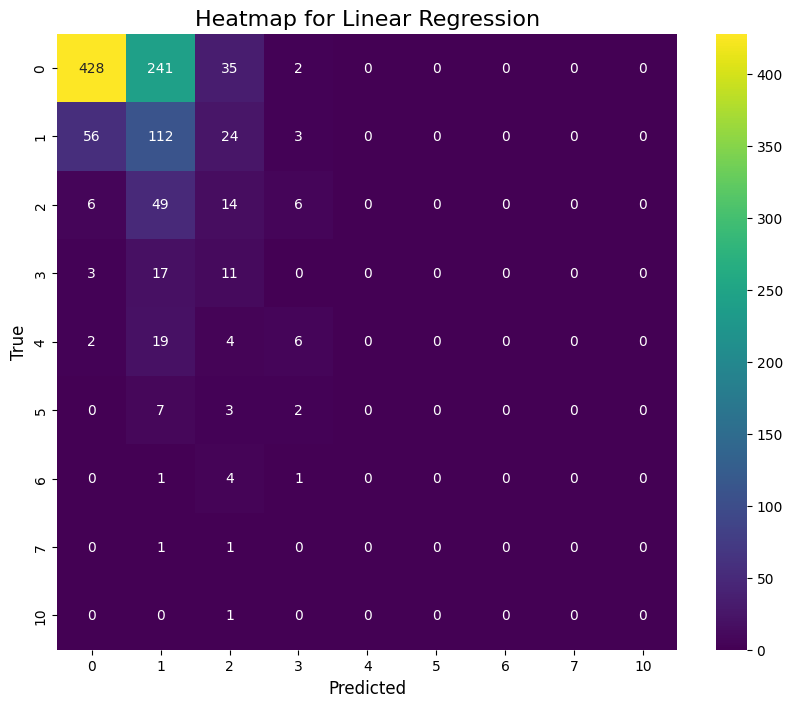


===== Training and Evaluating: Decision Tree Regressor =====
Cross-Validation RMSE Scores: [1.60482762 1.44473671 1.49763965 1.63588598 1.61259816 1.6286443
 1.45702829 1.50334536 1.53447383 1.44889295]
Mean CV RMSE: 1.5368 +/- 0.0734
Model fitting complete.
RMSE on the test set with rounded predictions: 1.4596

--- Classification-like Metrics for Decision Tree Regressor ---
Accuracy: 0.5600
Precision (weighted): 0.5725
Recall (weighted): 0.5600
Precision (macro): 0.1128
Recall (macro): 0.1127
------------------------------------------------------------------


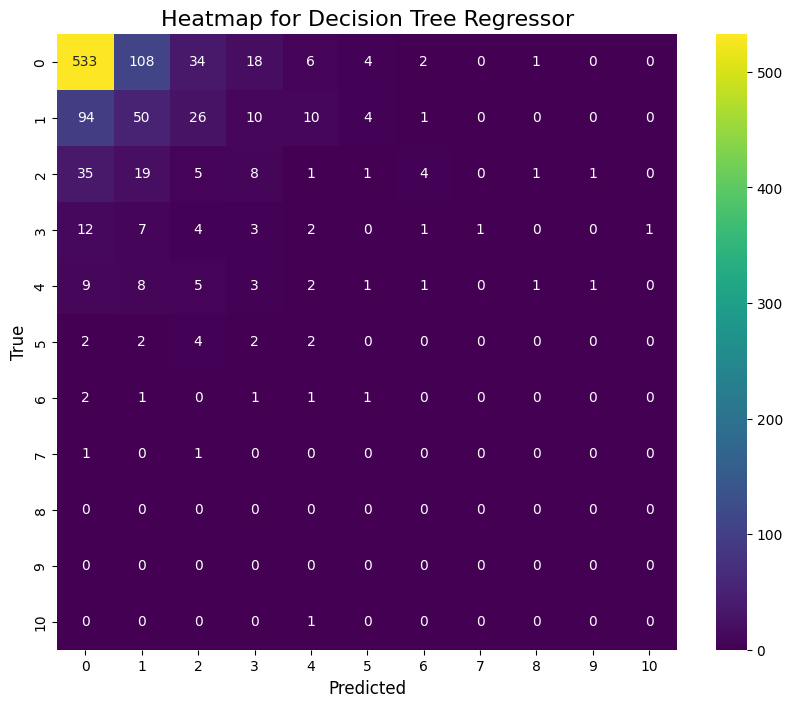


===== Training and Evaluating: Random Forest Regressor =====
Cross-Validation RMSE Scores: [1.22847658 1.15374063 1.13315951 1.21202427 1.23505094 1.17401405
 1.16569909 1.30905512 1.22492939 1.14273044]
Mean CV RMSE: 1.1979 +/- 0.0514
Model fitting complete.
RMSE on the test set with rounded predictions: 1.1486

--- Classification-like Metrics for Random Forest Regressor ---
Accuracy: 0.5845
Precision (weighted): 0.6234
Recall (weighted): 0.5845
Precision (macro): 0.1554
Recall (macro): 0.1675
------------------------------------------------------------------


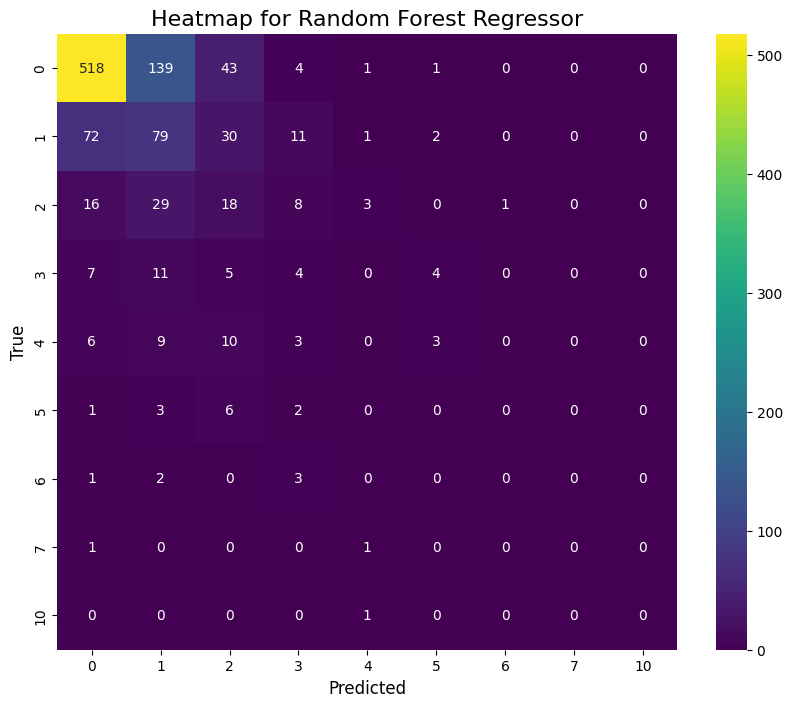


===== Training and Evaluating: XGBoost Regressor =====
Cross-Validation RMSE Scores: [1.17041311 1.16983959 1.12808758 1.21150012 1.19494035 1.21876824
 1.14481004 1.32310754 1.26409448 1.18097349]
Mean CV RMSE: 1.2007 +/- 0.0549
Model fitting complete.
RMSE on the test set with rounded predictions: 1.1498

--- Classification-like Metrics for XGBoost Regressor ---
Accuracy: 0.5873
Precision (weighted): 0.6101
Recall (weighted): 0.5873
Precision (macro): 0.1562
Recall (macro): 0.1608
------------------------------------------------------------------


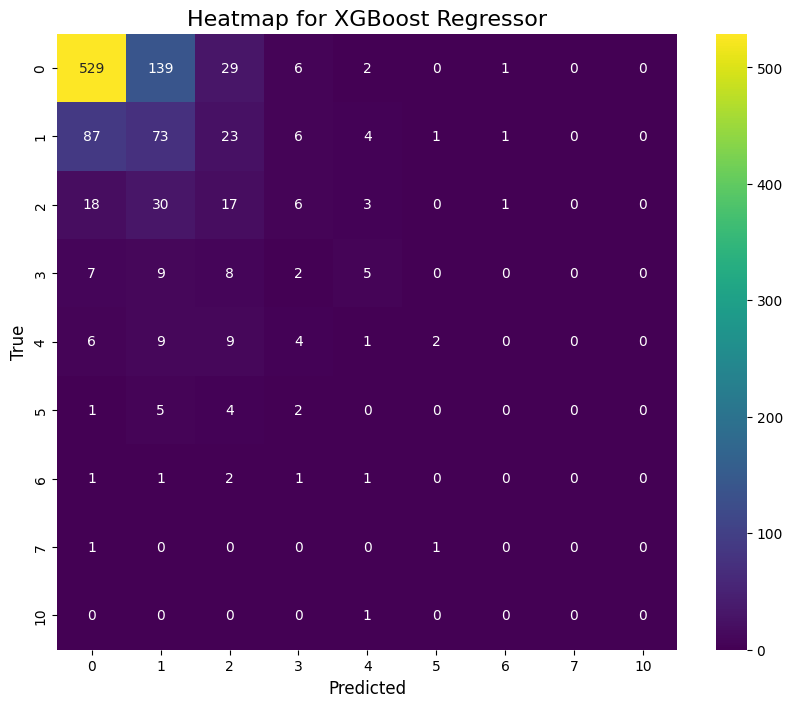


===== Training and Evaluating: Support Vector Regressor =====
Cross-Validation RMSE Scores: [1.19226264 1.20812722 1.05222076 1.24027071 1.18595996 1.21387707
 1.08626115 1.33118112 1.22833775 1.16454179]
Mean CV RMSE: 1.1903 +/- 0.0743
Model fitting complete.
RMSE on the test set with rounded predictions: 1.0895

--- Classification-like Metrics for Support Vector Regressor ---
Accuracy: 0.6468
Precision (weighted): 0.5999
Recall (weighted): 0.6468
Precision (macro): 0.1449
Recall (macro): 0.1552
------------------------------------------------------------------


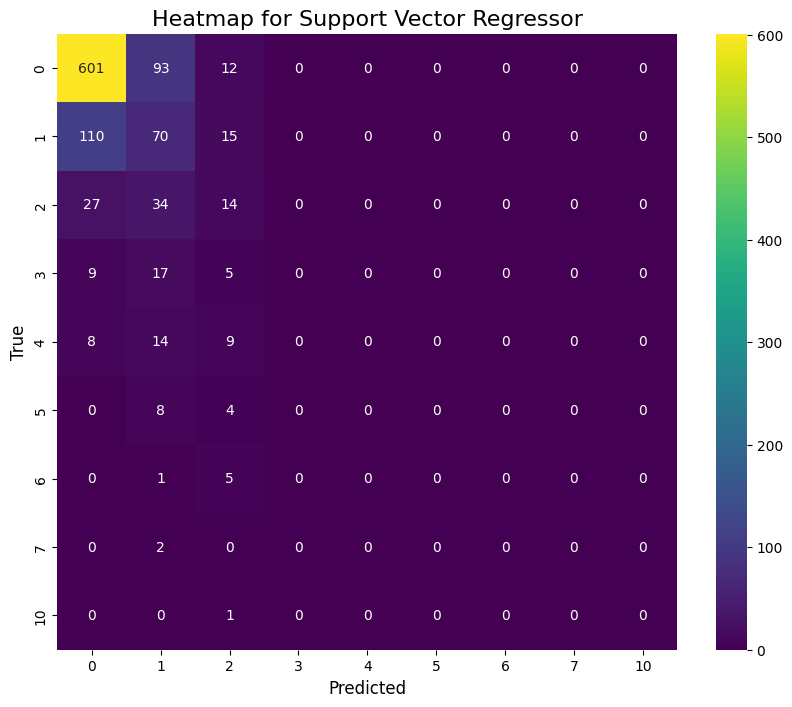


===== Training and Evaluating: K-Nearest Neighbors Regressor =====
Cross-Validation RMSE Scores: [1.15506473 1.1461379  1.08957322 1.15022867 1.09597372 1.13748717
 1.06797349 1.24801497 1.18801143 1.08838701]
Mean CV RMSE: 1.1367 +/- 0.0515
Model fitting complete.
RMSE on the test set with rounded predictions: 1.1105

--- Classification-like Metrics for K-Nearest Neighbors Regressor ---
Accuracy: 0.5694
Precision (weighted): 0.6110
Recall (weighted): 0.5694
Precision (macro): 0.1540
Recall (macro): 0.1576
------------------------------------------------------------------


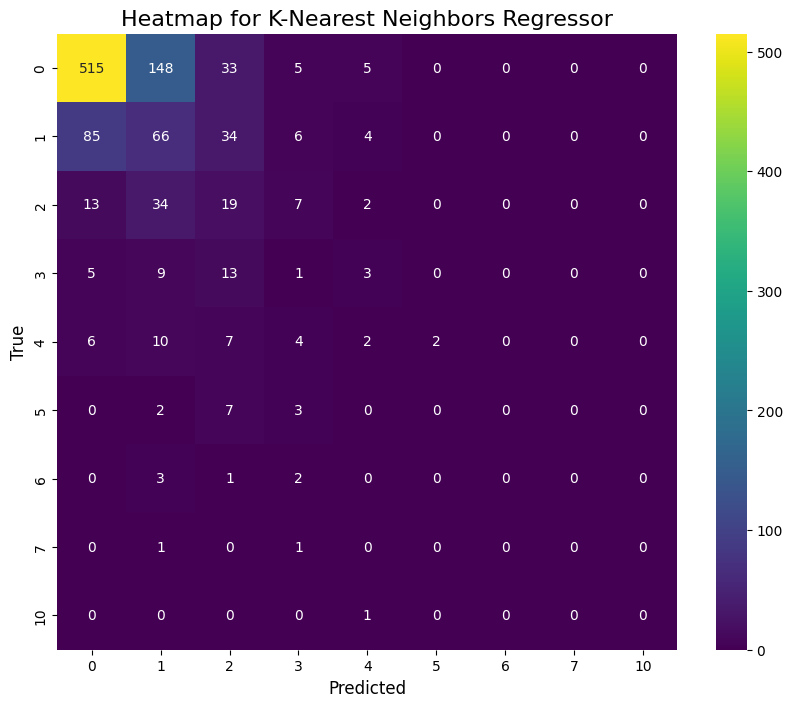


--- Best Model Found: Support Vector Regressor with RMSE: 1.0895 ---

Plotting heatmap for the best model: Support Vector Regressor

--- Classification-like Metrics for Best Model: Support Vector Regressor ---
Accuracy: 0.6468
Precision (weighted): 0.5999
Recall (weighted): 0.6468
Precision (macro): 0.1449
Recall (macro): 0.1552
------------------------------------------------------------------


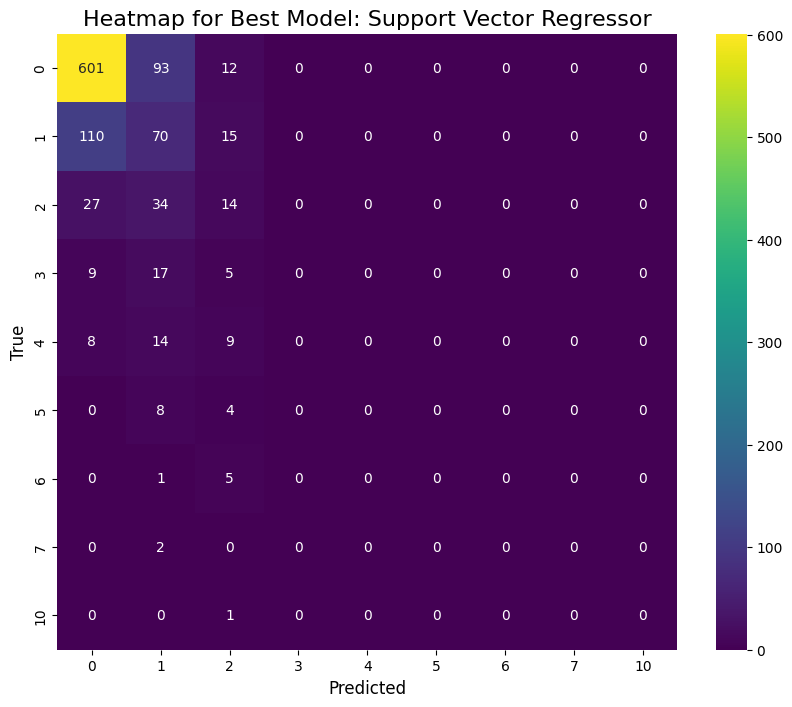

In [30]:
# Iterate through models, train, evaluate, and store results
for name, regressor in tqdm(models_to_train.items(), desc="Training Models"):
    trained_pipeline, rmse, y_pred_rounded = train_and_evaluate_model(
        name, regressor, X, y, X_test, y_test, preprocessor
    )
    model_results[name] = {'pipeline': trained_pipeline, 'rmse': rmse, 'predictions': y_pred_rounded}

    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_model_pipeline = trained_pipeline
        best_model_predictions = y_pred_rounded

print(f"\n--- Best Model Found: {best_model_name} with RMSE: {best_rmse:.4f} ---")

# Plot the predictions from the best model
if best_model_pipeline:
    print(f"\nPlotting heatmap for the best model: {best_model_name}")
    plot_regression_heatmap(y_test, best_model_predictions, title=f"Heatmap for Best Model: {best_model_name}")

#### Improving the best model throught grid search


Grid Search complete.

Best SVR Parameters: {'svr__C': 100, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
Best SVR Cross-Validation RMSE: 1.1651

===== Evaluating Best SVR Model on Test Set =====
RMSE on the test set with optimized SVR: 1.1088

--- Classification-like Metrics for Optimized SVR Model ---
Accuracy: 0.6308
Precision (weighted): 0.6136
Recall (weighted): 0.6308
Precision (macro): 0.1663
Recall (macro): 0.1698
------------------------------------------------------------------


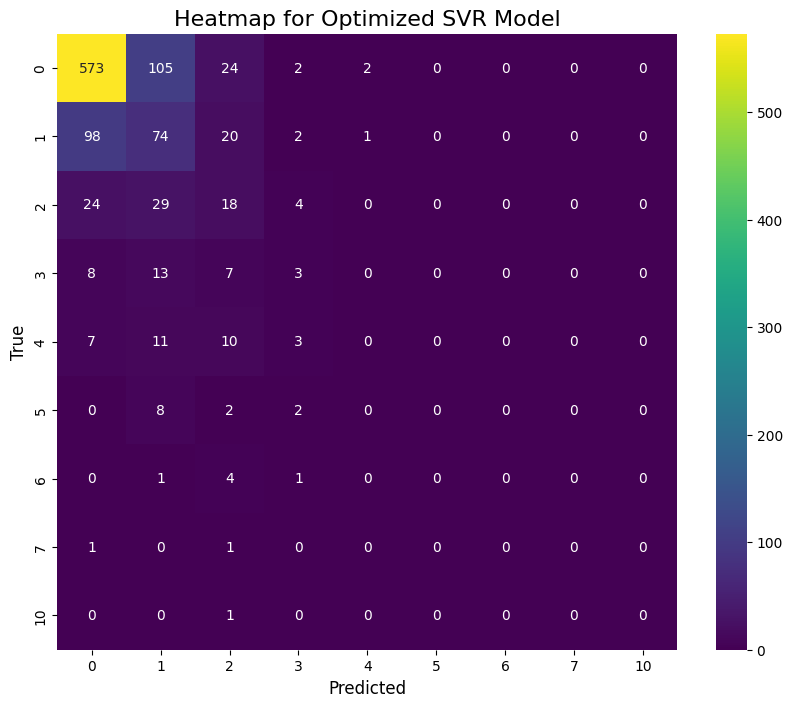

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

svr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('svr', SVR())
])

param_grid = {
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
}

grid_search_svr = GridSearchCV(
    svr_pipeline,
    param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1 
)

grid_search_svr.fit(X, y)

print("\nGrid Search complete.")

# Get the best parameters and best estimator
best_svr_params = grid_search_svr.best_params_
best_svr_pipeline = grid_search_svr.best_estimator_
best_svr_rmse_cv = np.sqrt(-grid_search_svr.best_score_)

print(f"\nBest SVR Parameters: {best_svr_params}")
print(f"Best SVR Cross-Validation RMSE: {best_svr_rmse_cv:.4f}")

# Evaluate the best SVR model on the test set
print("\n===== Evaluating Best SVR Model on Test Set =====")
y_pred_best_svr = best_svr_pipeline.predict(X_test)
y_pred_best_svr_rounded = np.round(y_pred_best_svr)
test_rmse_best_svr = np.sqrt(mean_squared_error(y_test, y_pred_best_svr_rounded))
print(f"RMSE on the test set with optimized SVR: {test_rmse_best_svr:.4f}")

plot_regression_heatmap(y_test, y_pred_best_svr_rounded, title="Heatmap for Optimized SVR Model")

In [32]:
MODEL_DIR = '../models/regressor'
MODEL_PATH = os.path.join(MODEL_DIR, 'best.pkl')

os.makedirs(MODEL_DIR, exist_ok=True)

print(f"\nSaving the best SVR model to {MODEL_PATH}")
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(best_svr_pipeline, f)
print("Model saved successfully!")


Saving the best SVR model to ../models/regressor/best.pkl
Model saved successfully!
